In [2]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 5.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl size=2611212 sha256=2d79e4cde2e930534b452e6e2f8529c81f5cb0d5fdca9c13d653f144cbb0a4bb
  Stored in directory: /root/.cache/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise


All imports successful!
Initializing models...

Generating recommendations for user 1 with history [101, 102]
Getting recommendations with weights: {'content': 0.5, 'collaborative': 0.3, 'popularity': 0.2}
Content-based found: 6 items
Collaborative found: 4 items
Popularity found: 8 items
Combining scores for 8 unique items

=== Final Weighted Hybrid Recommendations ===
Item 107: Score 0.633 - comedy funny humor
Item 108: Score 0.594 - fantasy magic adventure
Item 106: Score 0.500 - drama emotional family
Item 105: Score 0.305 - horror thriller scary
Item 104: Score 0.178 - documentary nature animals

=== Testing Different Weight Combinations ===

Comparing different weight combinations:
Getting recommendations with weights: {'content': 0.6, 'collaborative': 0.3, 'popularity': 0.1}
Content-based found: 6 items
Collaborative found: 4 items
Popularity found: 8 items
Combining scores for 8 unique items

1. Weights {'content': 0.6, 'collaborative': 0.3, 'popularity': 0.1}:
   Item 108: 0.6

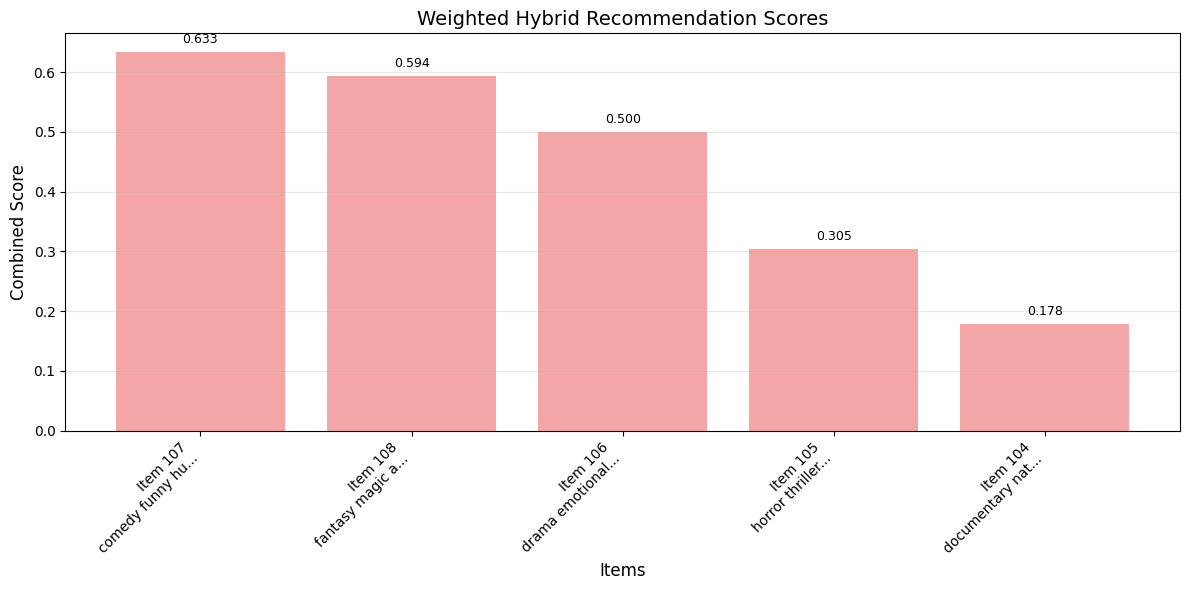


=== Model Comparison ===
Content-Based only:
  Item 107: 0.157
  Item 108: 0.157
  Item 103: 0.000

Collaborative Filtering only:
  Item 106: 0.639
  Item 105: 0.511
  Item 108: 0.435

Popularity only:
  Item 106: 1.000
  Item 104: 0.917
  Item 101: 0.875


In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

print("All imports successful!")

# Генерация sample данных
def generate_sample_data():
    users = [1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 5, 5, 1, 2]
    items = [101, 102, 103, 101, 104, 102, 105, 106, 103, 107, 104, 108, 104, 103]
    ratings = [5, 4, 3, 4, 5, 2, 4, 5, 3, 4, 5, 2, 4, 3]

    item_descriptions = {
        101: "action movie adventure superhero",
        102: "romantic comedy love relationship",
        103: "sci-fi future space technology",
        104: "documentary nature animals",
        105: "horror thriller scary",
        106: "drama emotional family",
        107: "comedy funny humor",
        108: "fantasy magic adventure"
    }

    return users, items, ratings, item_descriptions

# Инициализация данных
users, items, ratings, item_descriptions = generate_sample_data()

class ContentBasedRecommender:
    def __init__(self, item_descriptions):
        self.item_descriptions = item_descriptions
        self.vectorizer = TfidfVectorizer()
        self.item_vectors = None
        self._fit()

    def _fit(self):
        descriptions = [self.item_descriptions[item] for item in sorted(self.item_descriptions.keys())]
        self.item_vectors = self.vectorizer.fit_transform(descriptions)
        self.item_ids = sorted(self.item_descriptions.keys())

    def predict(self, user_history, top_k=5):
        if not user_history:
            return {item: 0.5 for item in self.item_ids[:top_k]}

        user_profile = self._get_user_profile(user_history)
        if user_profile is None:
            return {item: 0.5 for item in self.item_ids[:top_k]}

        similarities = cosine_similarity(user_profile, self.item_vectors).flatten()

        item_scores = list(zip(self.item_ids, similarities))
        item_scores.sort(key=lambda x: x[1], reverse=True)

        recommended = [(item, score) for item, score in item_scores
                      if item not in user_history][:top_k]

        return dict(recommended)

    def _get_user_profile(self, user_history):
        history_vectors = []
        for item in user_history:
            if item in self.item_ids:
                idx = self.item_ids.index(item)
                history_vectors.append(self.item_vectors[idx].toarray())

        if not history_vectors:
            return None

        return np.mean(history_vectors, axis=0)

class CollaborativeFilteringRecommender:
    def __init__(self, users, items, ratings):
        self.users = users
        self.items = items
        self.ratings = ratings
        self.user_item_matrix = None
        self.svd_model = None
        self._fit()

    def _fit(self):
        # Создаем user-item матрицу
        df = pd.DataFrame({
            'user': self.users,
            'item': self.items,
            'rating': self.ratings
        })

        # Создаем разреженную матрицу пользователь-товар
        self.user_item_matrix = df.pivot_table(
            index='user',
            columns='item',
            values='rating',
            fill_value=0
        )

        # Применяем SVD для снижения размерности
        self.svd_model = TruncatedSVD(n_components=2, random_state=42)
        self.user_factors = self.svd_model.fit_transform(self.user_item_matrix)
        self.item_factors = self.svd_model.components_.T

        self.all_users = list(self.user_item_matrix.index)
        self.all_items = list(self.user_item_matrix.columns)

    def predict(self, user_id, top_k=5):
        if user_id not in self.all_users:
            # Cold start: возвращаем популярные товары
            return self._get_popular_items(top_k)

        user_history = self._get_user_history(user_id)
        user_idx = self.all_users.index(user_id)

        # Получаем факторы пользователя
        user_vector = self.user_factors[user_idx]

        # Вычисляем схожесть со всеми товарами
        predictions = {}
        for item_idx, item_id in enumerate(self.all_items):
            if item_id not in user_history:
                item_vector = self.item_factors[item_idx]
                score = np.dot(user_vector, item_vector)
                predictions[item_id] = score

        # Сортируем и возвращаем top_k
        sorted_predictions = dict(sorted(
            predictions.items(),
            key=lambda x: x[1],
            reverse=True
        )[:top_k])

        return sorted_predictions

    def _get_user_history(self, user_id):
        user_history = set()
        for u, i in zip(self.users, self.items):
            if u == user_id:
                user_history.add(i)
        return user_history

    def _get_popular_items(self, top_k):
        # Простая популярность на основе количества взаимодействий
        item_counts = {}
        for item in self.items:
            item_counts[item] = item_counts.get(item, 0) + 1

        popular_items = dict(sorted(
            item_counts.items(),
            key=lambda x: x[1],
            reverse=True
        )[:top_k])

        # Нормализуем к 0-1
        max_count = max(popular_items.values()) if popular_items else 1
        return {item: count/max_count for item, count in popular_items.items()}

class PopularityRecommender:
    def __init__(self, items, ratings):
        self.item_popularity = self._calculate_popularity(items, ratings)

    def _calculate_popularity(self, items, ratings):
        item_ratings = {}
        item_counts = {}

        for item, rating in zip(items, ratings):
            if item not in item_ratings:
                item_ratings[item] = 0
                item_counts[item] = 0
            item_ratings[item] += rating
            item_counts[item] += 1

        popularity = {}
        for item in item_ratings:
            avg_rating = item_ratings[item] / item_counts[item]
            normalized_rating = (avg_rating - 1) / 4  # нормализуем к 0-1
            popularity[item] = normalized_rating

        return popularity

    def predict(self, user_history=None, top_k=5):
        sorted_popular = dict(sorted(
            self.item_popularity.items(),
            key=lambda x: x[1],
            reverse=True
        )[:top_k])
        return sorted_popular

class WeightedHybridRecommender:
    def __init__(self, content_model, cf_model, popularity_model, weights=None):
        self.content_model = content_model
        self.cf_model = cf_model
        self.popularity_model = popularity_model

        self.weights = weights or {
            'content': 0.4,
            'collaborative': 0.4,
            'popularity': 0.2
        }

        total = sum(self.weights.values())
        self.weights = {k: v/total for k, v in self.weights.items()}

    def recommend(self, user_id, user_history, top_k=10, custom_weights=None):
        weights = custom_weights or self.weights

        print(f"Getting recommendations with weights: {weights}")

        # Получаем предсказания от всех моделей
        content_recs = self.content_model.predict(user_history, top_k*3)
        cf_recs = self.cf_model.predict(user_id, top_k*3)
        popularity_recs = self.popularity_model.predict(user_history, top_k*3)

        print(f"Content-based found: {len(content_recs)} items")
        print(f"Collaborative found: {len(cf_recs)} items")
        print(f"Popularity found: {len(popularity_recs)} items")

        # Нормализуем скоринги
        content_recs = self._normalize_scores(content_recs)
        cf_recs = self._normalize_scores(cf_recs)
        popularity_recs = self._normalize_scores(popularity_recs)

        # Комбинируем скоринги
        combined_scores = self._combine_scores(
            content_recs, cf_recs, popularity_recs, weights
        )

        # Сортируем и возвращаем top_k
        final_recommendations = dict(sorted(
            combined_scores.items(),
            key=lambda x: x[1],
            reverse=True
        )[:top_k])

        return final_recommendations

    def _normalize_scores(self, recommendations):
        if not recommendations:
            return {}

        scores = list(recommendations.values())
        min_score, max_score = min(scores), max(scores)

        if max_score == min_score:
            return {item: 0.5 for item in recommendations}

        normalized = {}
        for item, score in recommendations.items():
            normalized[item] = (score - min_score) / (max_score - min_score)

        return normalized

    def _combine_scores(self, content_recs, cf_recs, popularity_recs, weights):
        all_items = set(content_recs.keys()) | set(cf_recs.keys()) | set(popularity_recs.keys())

        print(f"Combining scores for {len(all_items)} unique items")

        combined_scores = {}
        for item in all_items:
            total_score = 0
            total_score += content_recs.get(item, 0) * weights['content']
            total_score += cf_recs.get(item, 0) * weights['collaborative']
            total_score += popularity_recs.get(item, 0) * weights['popularity']
            combined_scores[item] = total_score

        return combined_scores

def plot_recommendation_scores(recommendations, item_descriptions):
    """Визуализация скорингов рекомендаций"""
    if not recommendations:
        print("No recommendations to plot")
        return

    items = list(recommendations.keys())
    scores = list(recommendations.values())
    descriptions = [f"Item {item}\n{item_descriptions.get(item, '')[:15]}..." for item in items]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(descriptions, scores, color='lightcoral', alpha=0.7)

    plt.title('Weighted Hybrid Recommendation Scores', fontsize=14)
    plt.xlabel('Items', fontsize=12)
    plt.ylabel('Combined Score', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)

    # Добавляем значения на бары
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

# Основная execution часть
print("Initializing models...")
content_model = ContentBasedRecommender(item_descriptions)
cf_model = CollaborativeFilteringRecommender(users, items, ratings)
popularity_model = PopularityRecommender(items, ratings)

# Создание гибридной модели
hybrid_recommender = WeightedHybridRecommender(
    content_model=content_model,
    cf_model=cf_model,
    popularity_model=popularity_model,
    weights={'content': 0.5, 'collaborative': 0.3, 'popularity': 0.2}
)

# Тестирование для пользователя 1
user_id = 1
user_history = [101, 102]  # История пользователя

print(f"\nGenerating recommendations for user {user_id} with history {user_history}")

# Получаем рекомендации
recommendations = hybrid_recommender.recommend(
    user_id=user_id,
    user_history=user_history,
    top_k=5
)

print("\n=== Final Weighted Hybrid Recommendations ===")
for item, score in recommendations.items():
    desc = item_descriptions.get(item, "No description")
    print(f"Item {item}: Score {score:.3f} - {desc}")

# Тестирование различных весов
print("\n=== Testing Different Weight Combinations ===")
weight_combinations = [
    {'content': 0.6, 'collaborative': 0.3, 'popularity': 0.1},
    {'content': 0.3, 'collaborative': 0.6, 'popularity': 0.1},
    {'content': 0.4, 'collaborative': 0.4, 'popularity': 0.2},
    {'content': 0.5, 'collaborative': 0.4, 'popularity': 0.1},
]

print("\nComparing different weight combinations:")
for i, weights in enumerate(weight_combinations, 1):
    recs = hybrid_recommender.recommend(
        user_id=user_id,
        user_history=user_history,
        top_k=3,
        custom_weights=weights
    )
    print(f"\n{i}. Weights {weights}:")
    for item, score in recs.items():
        desc_short = item_descriptions.get(item, "")[:20]
        print(f"   Item {item}: {score:.3f} - {desc_short}")

# Визуализация
print("\nGenerating visualization...")
plot_recommendation_scores(recommendations, item_descriptions)

print("\n=== Model Comparison ===")
print("Content-Based only:")
content_only = content_model.predict(user_history, top_k=3)
for item, score in content_only.items():
    print(f"  Item {item}: {score:.3f}")

print("\nCollaborative Filtering only:")
cf_only = cf_model.predict(user_id, top_k=3)
for item, score in cf_only.items():
    print(f"  Item {item}: {score:.3f}")

print("\nPopularity only:")
pop_only = popularity_model.predict(top_k=3)
for item, score in pop_only.items():
    print(f"  Item {item}: {score:.3f}")